In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
from hashlib import sha256

from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database import fit_model, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

dir_plots = 'plots'
dir_fitting_results = 'fitting_results'

# Installing required packages

Please install the required packages with exact version numbers, otherwise you will not be able to unpickle the author provided results. In your terminal:

```conda env create -f env_lcfit.yml```
```conda activate lcfit```

Afterward, launch your IDE or jupyter notebook / lab, and open this notebook. Make sure the correct kernel is loaded in your IDE / notebook / jupyter lab.

# Before running

The whole learning curve database needs to be fitted. This takes around 13 hours. You can do this with the script ```fit_database.py``` (parallelizeable for running on a compute cluster). Or you can load the author provided results, the directory that contains them should be in ```dir_fitting_results```. The path ```dir_plots``` is the directory where all plots will be stored. The file ```database-accuracy.csv``` should be in the same directory as this jupyter notebook (you can find this file in ```/python/lcdb/database.tar.7z```).

# Preprocessing
The data was spread over multiple files. Here, we load the different dataframes and combine them into 1 big dataframe called ``df_total``.

In [4]:
fn_df_total = dir_fitting_results + '/df_total.gz'
if exists(fn_df_total):
    df_total = pd.read_pickle(fn_df_total)
else:
    [df_anchors_and_scores, df_metrics, df_extrapolations] = load_from_parts(dir_fitting_results)
    df_total = prepare_total_dataframe(df_anchors_and_scores, df_metrics, df_extrapolations)
    df_total.to_pickle(fn_df_total, protocol=3)
# df_total.to_csv("df.csv")

In [5]:
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,...,percentage,percentage_bucket,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures,NumberOfClasses
0,3,SVC_linear,45,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.9585686965063442, 65.717112761228, 1.424918...",0,0,5.918595e-07,0.000045,0.000141,...,0.017388,0.05,37.0,37.0,37,37,37,37,37,2
1,3,SVC_linear,64,"[0.6872896626693055, 0.7356441492894228, 0.779...","[1.0179902627671116, 7.256505337543426, 0.8682...",0,0,6.533791e-07,0.000904,0.001647,...,0.024730,0.05,37.0,37.0,37,37,37,37,37,2
2,3,SVC_linear,91,"[0.6873537192715493, 0.7353498699373091, 0.779...","[0.9445764062845252, 1363.9883503403375, 2.047...",0,0,8.374107e-07,0.000273,0.000631,...,0.035162,0.05,37.0,37.0,37,37,37,37,37,2
3,3,SVC_linear,128,"[0.6872911905416228, 0.7354931238245204, 0.779...","[0.9560185696564745, 191.797847699449, 1.64180...",0,0,8.702641e-07,0.000074,0.000196,...,0.049459,0.05,37.0,37.0,37,37,37,37,37,2
4,3,SVC_linear,181,"[0.6870080420321716, 0.7359803560370154, 0.779...","[0.9755968843816757, 22.420258498280724, 1.173...",0,0,1.250014e-06,0.000031,0.000015,...,0.069938,0.10,37.0,37.0,37,37,37,37,37,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723723,42734,sklearn.tree.ExtraTreeClassifier,8192,"[0.6069124382316534, 0.6068719349769798, 0.606...","[1.2272074914077795, -57.17612385505127, 0.000...",0,0,1.241574e-04,0.000265,0.000333,...,0.199130,0.20,20.0,20.0,20,20,20,20,20,3
723724,42734,sklearn.tree.ExtraTreeClassifier,11585,"[0.6057733224352649, 0.6059305920794467, 0.606...","[1.8826720732566837, 709.781423308746, -0.0010...",0,0,1.249676e-04,0.000199,0.000228,...,0.281606,0.40,20.0,20.0,20,20,20,20,20,3
723725,42734,sklearn.tree.ExtraTreeClassifier,16384,"[0.6049948452599763, 0.6052794176922707, 0.605...","[2.60139205065173, 709.782005466877, -0.001688...",0,0,1.223783e-04,0.000182,0.000172,...,0.398260,0.40,20.0,20.0,20,20,20,20,20,3
723726,42734,sklearn.tree.ExtraTreeClassifier,23170,"[0.6040939529608614, 0.6045179965299784, 0.604...","[3.699510568374257, 709.7788620132377, -0.0023...",0,0,1.215016e-04,0.000154,0.000120,...,0.563213,0.80,20.0,20.0,20,20,20,20,20,3


In [6]:
# collect differences into new DF group by id, learner and curve
df_diff = df_total[['openmlid', 'learner', 'curve_model', 'prediction', 'score', 'MSE_tst', 'L1_tst']].groupby(['openmlid', 'learner', 'curve_model']).agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values)),
    'MSE_tst': np.mean,
    'L1_tst': np.mean
})
df_diff['diff'] = df_diff.apply(lambda row: [p - s for p, s in zip(row['prediction'], row['score'])], axis=1)
df_diff = df_diff.reset_index()

In [7]:
df_diff

,openmlid,learner,curve_model,prediction,score,MSE_tst,L1_tst,diff
0,3,SVC_linear,exp2,"[0.6988870799100882, 0.7283073836689042, 0.767...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",4.909127e+10,1.971507e+04,"[0.01139027991008823, -0.006470216331096235, -..."
1,3,SVC_linear,exp3,"[0.7560428000087255, 0.7560428000087468, 0.756...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",6.037247e-03,5.951054e-02,"[0.06854600000872546, 0.02126520000874632, -0...."
2,3,SVC_linear,exp4,"[0.6874968, 0.7347776000000005, 0.7807, 0.8211...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",8.407278e-04,1.639903e-02,"[0.0, 0.0, 0.0, 0.0, -0.015564094478493606, -0..."
3,3,SVC_linear,expd3,"[0.687272054413439, 0.735423322236913, 0.78008...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",1.247193e-03,2.986748e-02,"[-0.00022474558656104815, 0.000645722236912504..."
4,3,SVC_linear,expp3,"[0.6871214799156888, 0.7360798461482199, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.920539e-03,5.062652e-02,"[-0.00037532008431118147, 0.001302246148219388..."
...,...,...,...,...,...,...,...,...
55515,42734,sklearn.tree.ExtraTreeClassifier,pow2,"[0.6137249273768567, 0.6152880033510812, 0.616...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",1.074884e-03,2.769704e-02,"[0.010068927376856718, -0.017323996648918705, ..."
55516,42734,sklearn.tree.ExtraTreeClassifier,pow3,"[0.603717112829432, 0.6200647622103047, 0.6200...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",2.403046e+48,8.942605e+22,"[6.111282943199736e-05, -0.012547237789695243,..."
55517,42734,sklearn.tree.ExtraTreeClassifier,pow4,"[0.6038751445939022, 0.6200643067444521, 0.620...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",3.779703e+87,3.298843e+42,"[0.00021914459390226515, -0.012547693255547832..."
55518,42734,sklearn.tree.ExtraTreeClassifier,vap3,"[0.6061064474122585, 0.6237978881794735, 0.623...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",9.013569e-03,5.586038e-02,"[0.0024504474122585274, -0.008814111820526493,..."


In [8]:
# collect differences into new DF group by id and learner
df_grouped_by_openmlid_and_learner_diff = df_total[['openmlid', 'learner', 'curve_model', 'prediction', 'score', 'MSE_tst', 'L1_tst']].groupby(['openmlid', 'learner']).agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values)),
    'MSE_tst': np.mean,
    'L1_tst': np.mean
})
df_grouped_by_openmlid_and_learner_diff['diff'] = df_grouped_by_openmlid_and_learner_diff.apply(lambda row: [s - p for p, s in zip(row['prediction'], row['score'])], axis=1)
df_grouped_by_openmlid_and_learner_diff = df_grouped_by_openmlid_and_learner_diff.reset_index()
df_grouped_by_openmlid_and_learner_diff

,openmlid,learner,prediction,score,MSE_tst,L1_tst,diff
0,3,SVC_linear,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.068205e+09,1.232308e+03,"[0.0003008005233479105, -0.0010272075051821483..."
1,3,SVC_poly,"[0.6774429470664582, 0.7307476290917562, 0.777...","[0.6777768000000002, 0.7295775999999997, 0.778...",1.730871e+10,2.900509e+03,"[0.0003338529335419338, -0.0011700290917564526..."
2,3,SVC_rbf,"[0.5623081205358389, 0.6275484438054288, 0.683...","[0.5620543999999996, 0.6286088, 0.6818024, 0.7...",6.786291e+15,1.734689e+06,"[-0.0002537205358392747, 0.0010603561945711215..."
3,3,SVC_sigmoid,"[0.5101278384973219, 0.510709185520904, 0.5123...","[0.5147808, 0.5016944, 0.5179679999999999, 0.5...",1.114658e+26,2.494552e+11,"[0.004652961502678132, -0.009014785520904067, ..."
4,3,sklearn.ensemble.ExtraTreesClassifier,"[0.674764003783587, 0.7332164682247961, 0.7883...","[0.6757776, 0.7298895999999997, 0.7916128, 0.8...",6.335816e+12,5.367108e+04,"[0.0010135962164129486, -0.003326868224796442,..."
...,...,...,...,...,...,...,...
3465,42734,sklearn.naive_bayes.MultinomialNB,"[0.7156999999906666, 0.7156999999976958, 0.715...","[0.7156999999999999, 0.7156999999999999, 0.715...",5.842032e+09,2.225182e+03,"[9.333311901116303e-12, 2.3040458430045874e-12..."
3466,42734,sklearn.neighbors.KNeighborsClassifier,"[0.7033189025741937, 0.7060865269701435, 0.706...","[0.7030519999999999, 0.7100999999999997, 0.705...",3.881702e+15,1.123351e+06,"[-0.0002669025741938169, 0.004013473029856218,..."
3467,42734,sklearn.neural_network.MLPClassifier,"[0.7142490548944467, 0.7142487032872741, 0.714...","[0.71438, 0.7139199999999999, 0.71437999999999...",2.834161e+91,8.026080e+43,"[0.00013094510555333727, -0.000328703287274190..."
3468,42734,sklearn.tree.DecisionTreeClassifier,"[0.6697885116509771, 0.6688173080030666, 0.665...","[0.6720919999999999, 0.665392, 0.666388, 0.645...",1.998666e+43,6.236223e+19,"[0.002303488349022831, -0.0034253080030666183,..."


In [9]:
df_grouped_by_openmlid_diff = df_total[['openmlid', 'prediction', 'score', 'MSE_tst', 'L1_tst']].groupby('openmlid').agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values)),
    'MSE_tst': lambda x: x.replace(np.inf, 10000).mean(skipna=True),
    'L1_tst': np.mean
})
df_grouped_by_openmlid_diff['diff'] = df_grouped_by_openmlid_diff.apply(lambda row: [s-p for p, s in zip(row['prediction'], row['score'])], axis=1)
df_grouped_by_openmlid_diff = df_grouped_by_openmlid_diff.reset_index()
df_grouped_by_openmlid_diff

,openmlid,prediction,score,MSE_tst,L1_tst,diff
0,3,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",6.192542e+24,1.385879e+10,"[0.0003008005233479105, -0.0010272075051821483..."
1,6,"[0.16839466760996552, 0.19780346754031125, 0.2...","[0.16836319999999985, 0.19796160000000002, 0.2...",1.898509e+278,2.278369e+205,"[-3.146760996566855e-05, 0.0001581324596887645..."
2,12,"[0.5674783975694655, 0.662290420765598, 0.7386...","[0.5685767999999997, 0.6582672, 0.743112799999...",7.418955e+65,5.160606e+30,"[0.0010984024305341622, -0.004023220765597912,..."
3,14,"[0.45386243533562076, 0.5190724832297078, 0.57...","[0.4540951999999996, 0.5182663999999999, 0.579...",1.645207e+25,3.617016e+10,"[0.00023276466437882615, -0.000806083229707876..."
4,16,"[0.5587523757286718, 0.6355257838104811, 0.699...","[0.5595559999999998, 0.6326232, 0.702225600000...",8.897872e+38,5.657570e+201,"[0.0008036242713280739, -0.0029025838104810298..."
...,...,...,...,...,...,...
192,41168,"[0.42704972353374054, 0.42721146565997015, 0.4...","[0.43000800000000006, 0.42381599999999997, 0.4...",1.029178e+277,8.560471e+135,"[0.002958276466259513, -0.003395465659970176, ..."
193,41169,"[0.046543830316052415, 0.04823411472179863, 0....","[0.049920000000000006, 0.03814, 0.059639999999...",1.468121e+300,1.131951e+284,"[0.0033761696839475913, -0.010094114721798629,..."
194,42732,"[0.8581388643760322, 0.8581388628184297, 0.858...","[0.85351, 0.86164, 0.859264, 0.851968000000000...",1.490030e+182,4.606020e+88,"[-0.00462886437603216, 0.003501137181570302, 0..."
195,42733,"[0.8309195834242732, 0.8309138652954907, 0.830...","[0.8308599999999998, 0.830988, 0.83084, 0.8305...",4.816339e+286,4.140864e+266,"[-5.958342427336838e-05, 7.413470450923221e-05..."


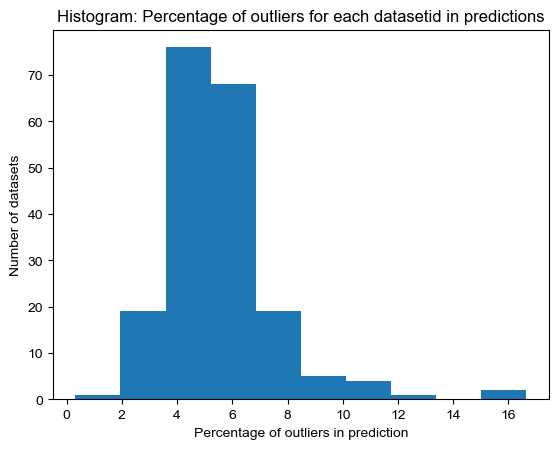

In [10]:
# find out percentage of ouliers on predictions per dataset
percentage_of_outliers_per_dataset = []
set_outliers_predictions = []
openmlids = set()
openmlf = set()
df_perc_of_outliers_features = pd.read_csv('perc_of_outliers.csv')
for index, row in df_perc_of_outliers_features.iterrows():
    openmlf.add(row['openmlid'])
    
for _, row in df_grouped_by_openmlid_diff.iterrows():
    diff_arr = row['diff']
    openmlids.add(row['openmlid'])
    # IQR
    q3, q1 = np.percentile(diff_arr, [75, 25])
    iqr = q3 - q1
    lower_bound = q1 - 10 * iqr
    upper_bound = q3 + 10 * iqr
    number_of_outliers = sum(i > upper_bound or i < lower_bound for i in diff_arr)

    percentage_of_outliers = (number_of_outliers / len(diff_arr)) * 100
    if row['openmlid'] in openmlf:
        percentage_of_outliers_per_dataset.append(percentage_of_outliers)
    
    if percentage_of_outliers > 5:
        set_outliers_predictions.append(row['openmlid'])

plt.hist(percentage_of_outliers_per_dataset)
plt.title('Histogram: Percentage of outliers for each datasetid in predictions')
plt.ylabel('Number of datasets')
plt.xlabel('Percentage of outliers in prediction')
plt.show()

In [11]:
df_total_grouped_by_learner_diff = df_total[['openmlid', 'learner', 'curve_model', 'prediction', 'score', 'MSE_tst', 'L1_tst']].groupby(['learner']).agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values))
})
df_total_grouped_by_learner_diff['diff'] = df_total_grouped_by_learner_diff.apply(lambda row: [s-p for p, s in zip(row['prediction'], row['score'])], axis=1)
df_total_grouped_by_learner_diff = df_total_grouped_by_learner_diff.reset_index()

df_total_grouped_by_learner_diff

,learner,prediction,score,diff
0,SVC_linear,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...","[0.0003008005233479105, -0.0010272075051821483..."
1,SVC_poly,"[0.6774429470664582, 0.7307476290917562, 0.777...","[0.6777768000000002, 0.7295775999999997, 0.778...","[0.0003338529335419338, -0.0011700290917564526..."
2,SVC_rbf,"[0.5623081205358389, 0.6275484438054288, 0.683...","[0.5620543999999996, 0.6286088, 0.6818024, 0.7...","[-0.0002537205358392747, 0.0010603561945711215..."
3,SVC_sigmoid,"[0.5101278384973219, 0.510709185520904, 0.5123...","[0.5147808, 0.5016944, 0.5179679999999999, 0.5...","[0.004652961502678132, -0.009014785520904067, ..."
4,sklearn.discriminant_analysis.LinearDiscrimina...,"[0.1113113853926393, 0.156462019612718, 0.2125...","[0.10683519999999998, 0.16739199999999999, 0.2...","[-0.0044761853926393175, 0.01092998038728199, ..."
5,sklearn.discriminant_analysis.QuadraticDiscrim...,"[0.040888414389087635, 0.06714084374710895, 0....","[0.04122, 0.06493636363636363, 0.0826691666666...","[0.00033158561091236466, -0.002204480110745324..."
6,sklearn.ensemble.ExtraTreesClassifier,"[0.674764003783587, 0.7332164682247961, 0.7883...","[0.6757776, 0.7298895999999997, 0.7916128, 0.8...","[0.0010135962164129486, -0.003326868224796442,..."
7,sklearn.ensemble.GradientBoostingClassifier,"[0.6769076285217339, 0.7652228176333856, 0.829...","[0.6780552, 0.7606647999999999, 0.835108800000...","[0.0011475714782660518, -0.0045580176333857025..."
8,sklearn.ensemble.RandomForestClassifier,"[0.6497976944855182, 0.7089671572277496, 0.762...","[0.6498639999999999, 0.7088048000000003, 0.763...","[6.630551448172373e-05, -0.0001623572277492657..."
9,sklearn.linear_model.LogisticRegression,"[0.658692, 0.7141679999999998, 0.7606407999999...","[0.658692, 0.7141679999999998, 0.7606407999999...","[0.0, 0.0, 0.0, 0.0, 0.005696004755615824, 0.0..."


The meaning of the columns are:
- openmlid: the dataset
- learner: the learner used for the classification task (e.g. SVM, etc.)
- max_anchor_seen: the largest training set point on the averaged learning curve used for fitting the curve model
- anchor_prediction: the x-values on the learning curve (the training set sizes)
- score: the y-values on the learning curve (the accuracy of the learner), note that this is an average over multiple learning curves
- n: number of points on the curve used for fitting the learning curve model
- max_anchor_seen: the largest training set size used in curve fitting
- percentage: the percentage of points used (compared to the total on the curve) used for fitting
- percentage_bucket: a discretized version of the percentage, values are 0.05, 0.10, 0.20, 0.40, 0.80, 1.0.
- curve_model: the curve model that we attempted to fit
- fails_init: how many initial points needed to be tried during the fitting procedure
- fails_fit: how many times the fitting failed
- beta: the parameters of the best fit on the training points on the curve (out of 5 or more fitting attempts)
- MSEs: the MSE on either the training points of the curve (trn), MSE on the testing points on the curve (tst), MSE on the last point on the curve (tst last)
- L1: the same, but then for the L1 (absolute loss)

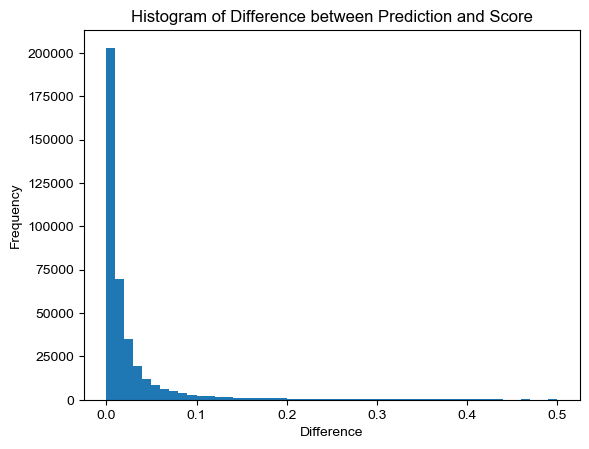

In [12]:
import matplotlib.pyplot as plt

# Extract the "diff" column from the DataFrame
difference_for_one_learner = df_total_grouped_by_learner_diff.iloc[10]['diff']

# Create a histogram of the flattened array
plt.hist(difference_for_one_learner, range=[0, 0.5], bins=50)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Prediction and Score')
plt.show()

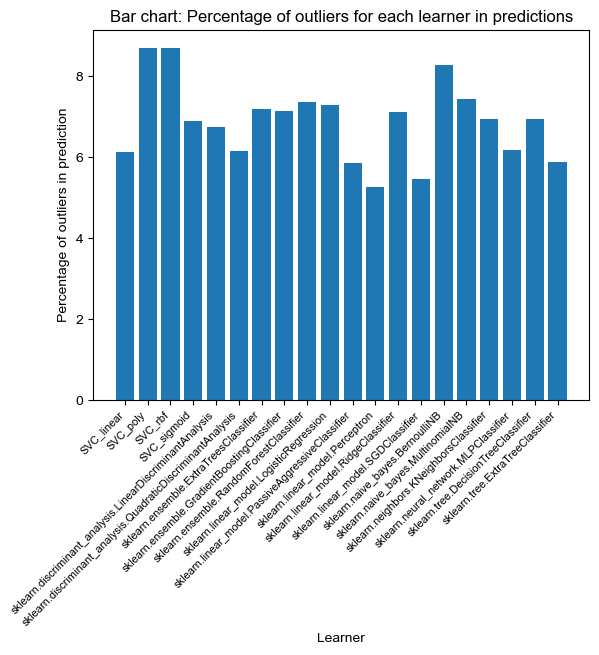

In [13]:
y = []
outlier_arr_per_model = []

for _, row in df_total_grouped_by_learner_diff.iterrows():
    diff_arr = row['diff']
    y.append(row['learner'])
    
    # IQR
    q3, q1 = np.percentile(diff_arr, [75, 25])
    iqr = q3 - q1
    lower_bound = q1 - 10 * iqr
    upper_bound = q3 + 10 * iqr
    
    number_of_outliers = sum(i > upper_bound or i < lower_bound for i in diff_arr)
    percentage_of_outliers = (number_of_outliers / len(diff_arr)) * 100
    
    outlier_arr_per_model.append(percentage_of_outliers)

plt.bar(y, outlier_arr_per_model)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('Learner')
plt.ylabel('Percentage of outliers in prediction')
plt.title('Bar chart: Percentage of outliers for each learner in predictions')
plt.show()


In [14]:
import numpy as np
from scipy.stats import friedmanchisquare

y = []  # Dependent variable or outcome variable
outlier_arr_per_model = []  # Number of outliers per model

for _, row in df_total_grouped_by_learner_diff.iterrows():
    diff_arr = row['diff']
    y.append(row['learner'])
    
    # IQR
    q3, q1 = np.percentile(diff_arr, [75, 25])
    iqr = q3 - q1
    lower_bound = q1 - 10 * iqr
    upper_bound = q3 + 10 * iqr
    
    number_of_outliers = sum(i > upper_bound or i < lower_bound for i in diff_arr)
    percentage_of_outliers = (number_of_outliers / len(diff_arr)) * 100
    
    outlier_arr_per_model.append([percentage_of_outliers])

# # Perform the Friedman test
statistic, p_value = friedmanchisquare(*outlier_arr_per_model)
p_value


0.45683612559196224

In [15]:
# Create an empty set to store the openmlid values
openmlid_set_feature_outliers = list()

# Iterate over the rows of the DataFrame
for index, row in df_perc_of_outliers_features.iterrows():
    perc_outliers = row['PercOutliers']
    if row['openmlid'] in openmlids:
        openmlid_set_feature_outliers.append(perc_outliers)

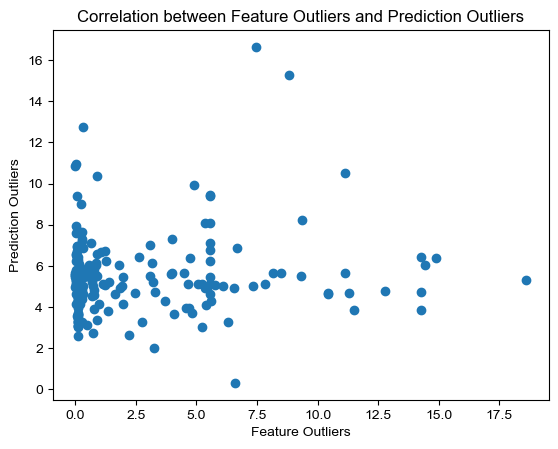

0.10116394396457672

In [16]:
# Create a DataFrame for outliers in features and predictions
df_outliers = pd.DataFrame({
    'prediction_outliers': percentage_of_outliers_per_dataset,
    'feature_outliers': openmlid_set_feature_outliers
})

# Calculate the correlation
correlation = df_outliers['feature_outliers'].corr(df_outliers['prediction_outliers'])

plt.scatter(df_outliers['feature_outliers'], df_outliers['prediction_outliers'])
plt.xlabel('Feature Outliers')
plt.ylabel('Prediction Outliers')
plt.title('Correlation between Feature Outliers and Prediction Outliers')
plt.show()
correlation

In [17]:
# average MSE and L1 for all anchors
df_grouped_by_openmlid_averaged_anchors = df_total[['openmlid', 'prediction', 'learner', 'score', 'curve_model', 'MSE_tst', 'L1_tst']].groupby(['openmlid', 'learner', 'curve_model']).agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values)),
    'MSE_tst': lambda x: x.replace(np.inf, 100000).mean(skipna=True),
    'L1_tst': np.mean
})
df_grouped_by_openmlid_averaged_anchors = df_grouped_by_openmlid_averaged_anchors.reset_index()
df_grouped_by_openmlid_averaged_anchors

,openmlid,learner,curve_model,prediction,score,MSE_tst,L1_tst
0,3,SVC_linear,exp2,"[0.6988870799100882, 0.7283073836689042, 0.767...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",4.909127e+10,1.971507e+04
1,3,SVC_linear,exp3,"[0.7560428000087255, 0.7560428000087468, 0.756...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",6.037247e-03,5.951054e-02
2,3,SVC_linear,exp4,"[0.6874968, 0.7347776000000005, 0.7807, 0.8211...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",8.407278e-04,1.639903e-02
3,3,SVC_linear,expd3,"[0.687272054413439, 0.735423322236913, 0.78008...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",1.247193e-03,2.986748e-02
4,3,SVC_linear,expp3,"[0.6871214799156888, 0.7360798461482199, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.920539e-03,5.062652e-02
...,...,...,...,...,...,...,...
55515,42734,sklearn.tree.ExtraTreeClassifier,pow2,"[0.6137249273768567, 0.6152880033510812, 0.616...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",1.074884e-03,2.769704e-02
55516,42734,sklearn.tree.ExtraTreeClassifier,pow3,"[0.603717112829432, 0.6200647622103047, 0.6200...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",2.403046e+48,8.942605e+22
55517,42734,sklearn.tree.ExtraTreeClassifier,pow4,"[0.6038751445939022, 0.6200643067444521, 0.620...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",3.779703e+87,3.298843e+42
55518,42734,sklearn.tree.ExtraTreeClassifier,vap3,"[0.6061064474122585, 0.6237978881794735, 0.623...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",9.013569e-03,5.586038e-02


In [18]:
my_curve_model = 'exp4'
my_error_type = 'MSE_tst'

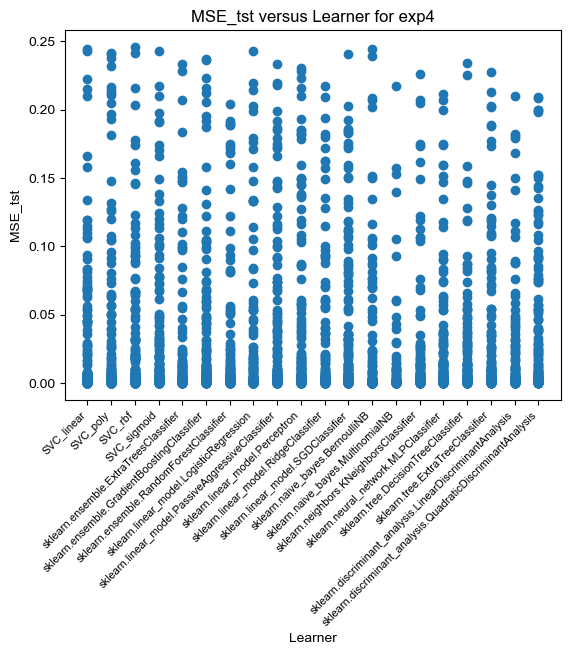

In [19]:
# filter_by_only_curve_model
df_filtered_by_curve = df_grouped_by_openmlid_averaged_anchors[df_grouped_by_openmlid_averaged_anchors['curve_model'] == my_curve_model]
Q1 = np.percentile(df_filtered_by_curve[my_error_type], 25)
Q3 = np.percentile(df_filtered_by_curve[my_error_type], 75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Find the outliers
outliers = df_filtered_by_curve[(df_filtered_by_curve[my_error_type] < Q1 - outlier_threshold) | (df_filtered_by_curve[my_error_type] > Q3 + outlier_threshold)]

df_filtered_by_curve.loc[outliers.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_filtered_by_curve = df_filtered_by_curve.interpolate(method='linear')

plt.scatter(df_filtered_by_curve['learner'], df_filtered_by_curve[my_error_type])
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel('Learner')
plt.ylabel(my_error_type)
plt.title(f'{my_error_type} versus Learner for {my_curve_model}')
plt.show()

In [20]:
df_mmf4 = df_grouped_by_openmlid_averaged_anchors[df_grouped_by_openmlid_averaged_anchors['curve_model'] == 'mmf4']
df_pow4 = df_grouped_by_openmlid_averaged_anchors[df_grouped_by_openmlid_averaged_anchors['curve_model'] == 'pow4']
df_exp4 = df_grouped_by_openmlid_averaged_anchors[df_grouped_by_openmlid_averaged_anchors['curve_model'] == 'exp4']
Q1_mmf4 = np.percentile(df_mmf4[my_error_type], 25)
Q3_mmf4 = np.percentile(df_mmf4[my_error_type], 75)
IQR_mmf4 = Q3_mmf4 - Q1_mmf4

Q1_pow4 = np.percentile(df_pow4[my_error_type], 25)
Q3_pow4 = np.percentile(df_pow4[my_error_type], 75)
IQR_pow4 = Q3_pow4 - Q1_pow4

Q1_exp4 = np.percentile(df_exp4[my_error_type], 25)
Q3_exp4 = np.percentile(df_exp4[my_error_type], 75)
IQR_exp4 = Q3_exp4 - Q1_exp4
outlier_threshold_mmf4 = 1.5 * IQR_mmf4
outlier_threshold_pow4 = 1.5 * IQR_pow4
outlier_threshold_exp4 = 1.5 * IQR_exp4

outliers_mmf4 = df_mmf4[(df_mmf4[my_error_type] < Q1 - outlier_threshold_mmf4) | (df_mmf4[my_error_type] > Q3 + outlier_threshold_mmf4)]
df_mmf4.loc[outliers_mmf4.index, my_error_type] = np.nan

outliers_pow4 = df_pow4[(df_pow4[my_error_type] < Q1 - outlier_threshold_pow4) | (df_pow4[my_error_type] > Q3 + outlier_threshold_pow4)]
df_pow4.loc[outliers_pow4.index, my_error_type] = np.nan

outliers_exp4 = df_exp4[(df_exp4[my_error_type] < Q1 - outlier_threshold_exp4) | (df_exp4[my_error_type] > Q3 + outlier_threshold_exp4)]
df_exp4.loc[outliers_exp4.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_mmf4 = df_mmf4.interpolate(method='linear')
df_pow4 = df_pow4.interpolate(method='linear')
df_exp4 = df_exp4.interpolate(method='linear')
df_combined = pd.concat([df_mmf4, df_pow4, df_exp4])

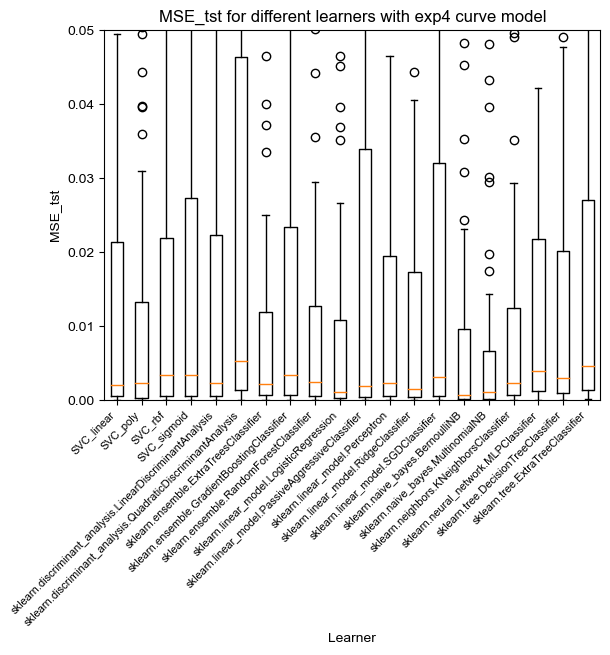

In [21]:
average_metric_by_learner = df_filtered_by_curve.groupby('learner')[my_error_type].median()

plt.boxplot(df_filtered_by_curve.groupby('learner')[my_error_type].apply(list), labels=average_metric_by_learner.index)
plt.xlabel('Learner')
plt.ylim(0, 0.05)
plt.ylabel(my_error_type)
plt.title(f'{my_error_type} for different learners with {my_curve_model} curve model')
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.show()

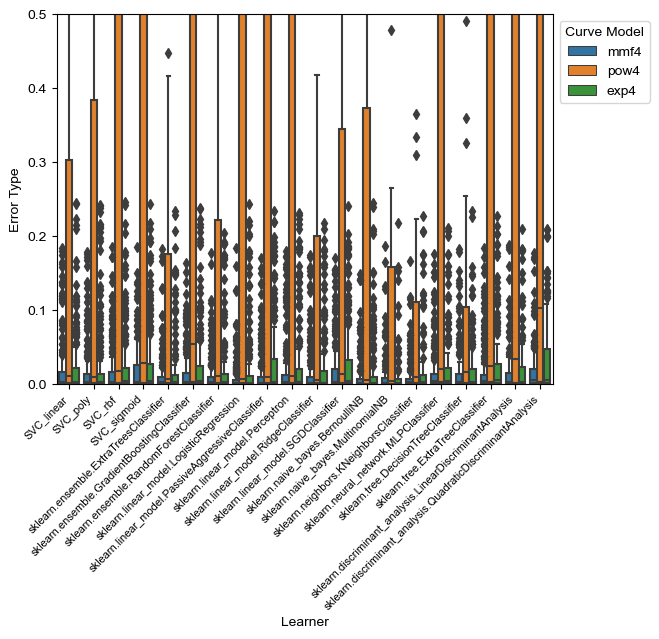

In [22]:
import seaborn as sns
df_combined = pd.concat([df_mmf4, df_pow4, df_exp4])

# Define a custom color palette
# colors = ["#FCC1B5", "#E0FCB5", "#7F9EF9"]  # Replace with your preferred colors

# # Set the custom color palette
# sns.set_palette(colors)

# Create the boxplot
sns.boxplot(x='learner', y=my_error_type, hue='curve_model', data=df_combined)

# Set labels and title
plt.xlabel('Learner')
plt.ylabel('Error Type')
plt.ylim(0, 0.5)
# Display the legend outside the plot
plt.legend(title='Curve Model', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45, fontsize=8, ha='right')

# Show the plot
plt.show()

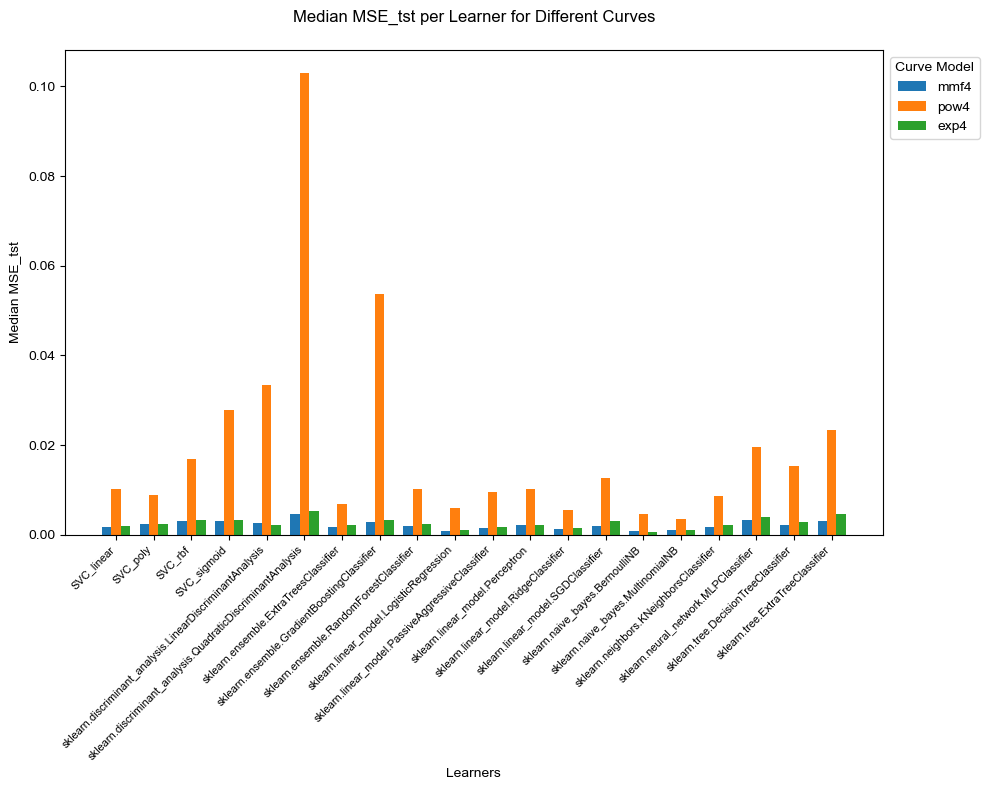

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))  # Set the figure size

# Calculate median errors
medians_mmf4 = df_mmf4.groupby('learner')[my_error_type].median()
medians_pow4 = df_pow4.groupby('learner')[my_error_type].median()
medians_exp4 = df_exp4.groupby('learner')[my_error_type].median()

# Generate x-axis positions for the bars
x = np.arange(len(medians_mmf4))

# Width of the bars
bar_width = 0.25

# Plotting bars for mmf4 curve
rects1 = ax.bar(x, medians_mmf4, bar_width, label='mmf4')

# Plotting bars for pow4 curve
rects2 = ax.bar(x + bar_width, medians_pow4, bar_width, label='pow4')

# Plotting bars for exp4 curve
rects3 = ax.bar(x + 2 * bar_width, medians_exp4, bar_width, label='exp4')

# Add labels, title, and legend
ax.set_xlabel('Learners')
ax.set_ylabel(f'Median {my_error_type}')
ax.set_title(f'Median {my_error_type} per Learner for Different Curves', pad=20)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(medians_mmf4.index, rotation=45, fontsize=8, ha='right')
# ax.set_ylim(0, 0.006)
ax.legend(title='Curve Model', bbox_to_anchor=(1, 1), loc='upper left')

# Add error values above bars where error is > 0.05
error_height = 0.01
# error_height_pow = 0.006
# for rect, height in zip(rects1, medians_mmf4):
#     if height > 0.1:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

# for rect, height in zip(rects2, medians_pow4):
#     if height > 0.006:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height_pow),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

# for rect, height in zip(rects3, medians_exp4):
#     if height > 0.1:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

plt.subplots_adjust(bottom=0.5)
# Display the chart
plt.tight_layout()
plt.show()


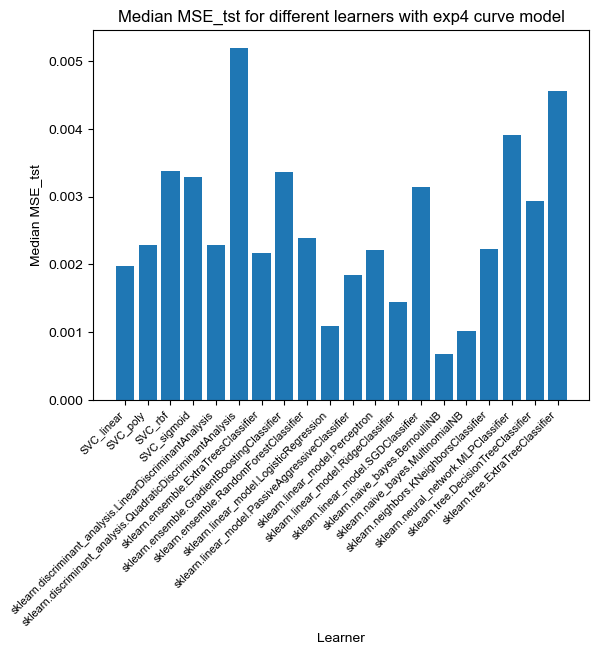

In [24]:
plt.bar(average_metric_by_learner.index, average_metric_by_learner)
plt.xlabel('Learner')
plt.ylabel(f'Median {my_error_type}')
plt.title(f'Median {my_error_type} for different learners with {my_curve_model} curve model')
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.show()

In [24]:
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
grouped_df = df_combined.groupby('learner')

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Learner', 'Friedman Chi-square', 'Friedman p-value'])

# Iterate over each learner group
for learner, group in grouped_df:

    # Extract the values for each group
    mmf4_values = group[group['curve_model'] == 'mmf4'][my_error_type].values
    pow4_values = group[group['curve_model'] == 'pow4'][my_error_type].values
    exp4_values = group[group['curve_model'] == 'exp4'][my_error_type].values

    # Perform Friedman test
    statistic, p_value = friedmanchisquare(mmf4_values, pow4_values, exp4_values)

    # Store the results in the DataFrame
    results_df = results_df.append({'Learner': learner, 'Friedman Chi-square': statistic, 'Friedman p-value': p_value}, ignore_index=True)

    # Perform Wilcoxon signed-rank test for pairwise comparisons
    if p_value < 0.05:  # If the Friedman test is significant

        # Compare mmf4 vs. pow4
        wilcoxon_stat, wilcoxon_p_value = wilcoxon(mmf4_values, pow4_values)

        if wilcoxon_p_value < 0.05:
            if np.median(mmf4_values) < np.median(pow4_values):
                print(f"Significant difference between mmf4 and pow4 for learner {learner}. mmf4 is better than pow4.")
            else:
                print(f"Significant difference between mmf4 and pow4 for learner {learner}. mmf4 is worse than pow4.")
        # Compare mmf4 vs. exp4
        wilcoxon_stat, wilcoxon_p_value = wilcoxon(mmf4_values, exp4_values)

        if wilcoxon_p_value < 0.05:
            if np.median(mmf4_values) < np.median(exp4_values):
                print(f"Significant difference between mmf4 and exp4 for learner {learner}. mmf4 is better than exp4")
            else:
                print(f"Significant difference between mmf4 and exp4 for learner {learner}. mmf4 is worse than exp4")
        # Compare pow4 vs. exp4
        wilcoxon_stat, wilcoxon_p_value = wilcoxon(pow4_values, exp4_values)

        if wilcoxon_p_value < 0.05:
            if np.median(pow4_values) < np.median(exp4_values):
                print(f"Significant difference between pow4 and exp4 for learner {learner}. pow4 is better than exp4")
            else:
                print(f"Significant difference between pow4 and exp4 for learner {learner}. pow4 is worse than exp4")


Significant difference between mmf4 and pow4 for learner SVC_linear. mmf4 is better than pow4.
Significant difference between pow4 and exp4 for learner SVC_linear. pow4 is worse than exp4
Significant difference between mmf4 and pow4 for learner SVC_poly. mmf4 is better than pow4.
Significant difference between pow4 and exp4 for learner SVC_poly. pow4 is worse than exp4
Significant difference between mmf4 and pow4 for learner SVC_rbf. mmf4 is better than pow4.
Significant difference between mmf4 and exp4 for learner SVC_rbf. mmf4 is better than exp4
Significant difference between pow4 and exp4 for learner SVC_rbf. pow4 is worse than exp4
Significant difference between mmf4 and pow4 for learner SVC_sigmoid. mmf4 is better than pow4.
Significant difference between pow4 and exp4 for learner SVC_sigmoid. pow4 is worse than exp4
Significant difference between mmf4 and pow4 for learner sklearn.discriminant_analysis.LinearDiscriminantAnalysis. mmf4 is better than pow4.
Significant difference b

/var/folders/kl/y7rcnhh17hddb2hfmshzn68c0000gn/T/ipykernel_729/1823289987.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learner': learner, 'Friedman Chi-square': statistic, 'Friedman p-value': p_value}, ignore_index=True)
/var/folders/kl/y7rcnhh17hddb2hfmshzn68c0000gn/T/ipykernel_729/1823289987.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learner': learner, 'Friedman Chi-square': statistic, 'Friedman p-value': p_value}, ignore_index=True)
/var/folders/kl/y7rcnhh17hddb2hfmshzn68c0000gn/T/ipykernel_729/1823289987.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learner': learner, 'Friedman Chi-square': statist

In [25]:
from scipy.stats import friedmanchisquare

# Find max len of values
desired_size = 0
for learner in average_metric_by_learner.index:
    filtered_data = df_filtered_by_curve[df_filtered_by_curve['learner'] == learner]
    len_filtered_data = len(filtered_data[my_error_type].values)
    desired_size = max(desired_size, len_filtered_data)
    
learner_metrics = []
learners = []

for learner in average_metric_by_learner.index:
    filtered_data = df_filtered_by_curve[df_filtered_by_curve['learner'] == learner]
    error_values = filtered_data[my_error_type].values
    
    # Calculate the mean value of error array
    median_value = np.median(error_values)
    
    # Determine the size difference between the array and desired size
    size_diff = desired_size - len(error_values)
    
    # Pad the array with the mean value if it's smaller than the desired size
    if size_diff > 0:
        padded_array = np.concatenate((error_values, np.full(size_diff, median_value)))
    
    # Keep the original array if it's already the desired size
    else:
        padded_array = error_values
    
    # Append the padded/truncated array to the learner_metrics list
    learner_metrics.append(padded_array)
    learners.append(learner)
    
# Perform Friedman test
f_statistic, p_value = friedmanchisquare(*learner_metrics)

# Print the results
print("Friedman results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

Friedman results:
F-statistic: 248.00596169553276
p-value: 7.840017859156749e-42


In [26]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Perform pairwise Wilcoxon signed-rank tests
p_values = []
pairs = []
rankings = []
for i in range(len(learner_metrics)):
    for j in range(i + 1, len(learner_metrics)):
        statistic, p = wilcoxon(learner_metrics[i], learner_metrics[j])
        p_values.append(p)
        pairs.append([(learners[i], learners[j])])
        rankings.append(statistic)

# Apply Holm's correction for multiple comparisons
rejected, adjusted_p_values, _, _ = multipletests(p_values, method='holm')

In [27]:
# Conduct pair-wise comparisons
rankings = {}

for learner in learners:
    rankings[learner] = 0
m = 0
comparisons = []
for i in range(len(learner_metrics)):
    for j in range(i + 1, len(learner_metrics)):
        learner_i = learners[i]
        learner_j = learners[j]
        if adjusted_p_values[m] < 0.05:
            median_i = average_metric_by_learner.loc[learner_i]
            median_j = average_metric_by_learner.loc[learner_j]
            if median_i < median_j:
                comparisons.append((learner_i, learner_j, "better", adjusted_p_values[m]))
            else:
                comparisons.append((learner_i, learner_j, "worse", adjusted_p_values[m]))
        else:
            comparisons.append((learner_i, learner_j, "equal", adjusted_p_values[m]))
        m = m + 1

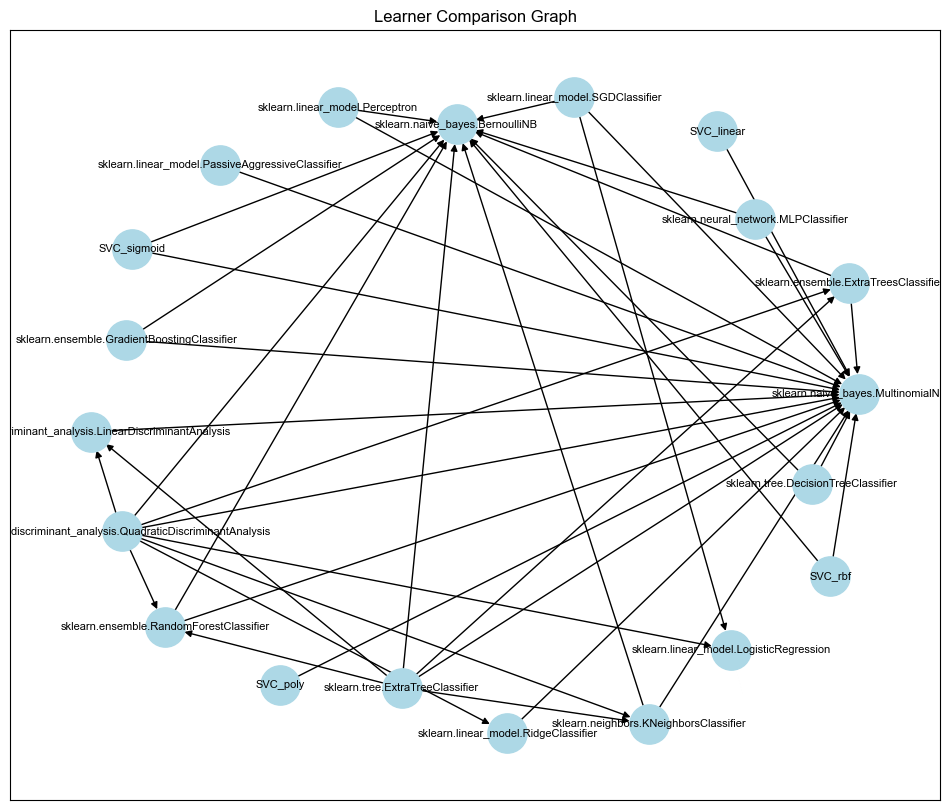

In [28]:
import networkx as nx

# Create an empty directed graph
graph = nx.DiGraph()

# Add learners as nodes to the graph
for learner in learners:
    graph.add_node(learner)

# Iterate over the comparisons and add directed edges based on the relationships
for learner_i, learner_j, relationship, p_value in comparisons:
    if relationship == "better":
        graph.add_edge(learner_j, learner_i)
    elif relationship == "worse":
        graph.add_edge(learner_i, learner_j)

plt.figure(figsize=(12, 10))

# Use the "spring" layout algorithm for node positioning
pos = nx.spring_layout(graph, k=8)  # You can adjust the seed value for different layouts

# Draw the graph with larger fonts and node sizes
nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', font_size=8, node_size=800)


# Add a title
plt.title("Learner Comparison Graph")

# Display the graph
plt.show()

In [29]:
outgoing_edges = graph.out_degree()

# Sort learners based on rank and average
sorted_learners = sorted(outgoing_edges, key=lambda x: (x[1], average_metric_by_learner.loc[x[0]]))

# Initialize variables
prev_rank = -1
initial_rank = 0
learner_rank = []

# Generate learner ranks and store in a list
for learner, count in sorted_learners:
    if count > prev_rank:
        prev_rank = count
        initial_rank += 1
    learner_rank.append([learner, initial_rank, average_metric_by_learner.loc[learner]])

# Convert learner ranks to a DataFrame for easy printing
df_rank_model = pd.DataFrame(learner_rank, columns=['Learner', 'Rank', 'Average Metric'])

# Print the number of outgoing edges and ranks for each learner
df_rank_model.to_latex

<bound method NDFrame.to_latex of                                               Learner  Rank  Average Metric
0                     sklearn.naive_bayes.BernoulliNB     1        0.000670
1                   sklearn.naive_bayes.MultinomialNB     1        0.001017
2             sklearn.linear_model.LogisticRegression     1        0.001094
3                sklearn.linear_model.RidgeClassifier     2        0.001447
4    sklearn.linear_model.PassiveAggressiveClassifier     2        0.001834
5                                          SVC_linear     2        0.001969
6   sklearn.discriminant_analysis.LinearDiscrimina...     2        0.002280
7                                            SVC_poly     2        0.002290
8               sklearn.ensemble.ExtraTreesClassifier     3        0.002163
9                     sklearn.linear_model.Perceptron     3        0.002215
10             sklearn.neighbors.KNeighborsClassifier     3        0.002225
11            sklearn.ensemble.RandomForestClassifier 

In [83]:
parameter = 'PercOutliers'
df_dataset = pd.read_csv('perc_of_outliers.csv')
df_total_with_parameter = pd.merge(df_grouped_by_openmlid_averaged_anchors, df_dataset[[parameter, 'openmlid']], on='openmlid')

In [84]:
df_total_with_parameter

,openmlid,learner,curve_model,prediction,score,MSE_tst,L1_tst,PercOutliers
0,3,SVC_linear,exp2,"[0.6988870799100882, 0.7283073836689042, 0.767...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",4.909127e+10,1.971507e+04,5.757196
1,3,SVC_linear,exp3,"[0.7560428000087255, 0.7560428000087468, 0.756...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",6.037247e-03,5.951054e-02,5.757196
2,3,SVC_linear,exp4,"[0.6874968, 0.7347776000000005, 0.7807, 0.8211...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",8.407278e-04,1.639903e-02,5.757196
3,3,SVC_linear,expd3,"[0.687272054413439, 0.735423322236913, 0.78008...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",1.247193e-03,2.986748e-02,5.757196
4,3,SVC_linear,expp3,"[0.6871214799156888, 0.7360798461482199, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.920539e-03,5.062652e-02,5.757196
...,...,...,...,...,...,...,...,...
55067,42734,sklearn.tree.ExtraTreeClassifier,pow2,"[0.6137249273768567, 0.6152880033510812, 0.616...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",1.074884e-03,2.769704e-02,0.094139
55068,42734,sklearn.tree.ExtraTreeClassifier,pow3,"[0.603717112829432, 0.6200647622103047, 0.6200...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",2.403046e+48,8.942605e+22,0.094139
55069,42734,sklearn.tree.ExtraTreeClassifier,pow4,"[0.6038751445939022, 0.6200643067444521, 0.620...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",3.779703e+87,3.298843e+42,0.094139
55070,42734,sklearn.tree.ExtraTreeClassifier,vap3,"[0.6061064474122585, 0.6237978881794735, 0.623...","[0.603656, 0.632612, 0.61308, 0.61456799999999...",9.013569e-03,5.586038e-02,0.094139


In [86]:
my_curve_model = 'pow4'
my_error_type = 'L1_tst'

In [87]:
df_total_with_parameter_averaged = df_total_with_parameter[['openmlid', 'prediction', 'score', 'curve_model', 'MSE_tst', 'L1_tst', parameter]].groupby(['openmlid', parameter, 'curve_model']).agg({
    'prediction': lambda x: list(np.hstack(x.values)),
    'score': lambda x: list(np.hstack(x.values)),
    'MSE_tst': lambda x: x.replace(np.inf, 1).mean(skipna=True),
    'L1_tst': np.mean
})
df_total_with_parameter_averaged = df_total_with_parameter_averaged.reset_index()
df_total_with_parameter_averaged

,openmlid,PercOutliers,curve_model,prediction,score,MSE_tst,L1_tst
0,3,5.757196,exp2,"[0.6988870799100882, 0.7283073836689042, 0.767...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",7.422003e+15,2.681110e+06
1,3,5.757196,exp3,"[0.7560428000087255, 0.7560428000087468, 0.756...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.819027e-01,1.451093e-01
2,3,5.757196,exp4,"[0.6874968, 0.7347776000000005, 0.7807, 0.8211...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",2.090806e-02,3.824414e-02
3,3,5.757196,expd3,"[0.687272054413439, 0.735423322236913, 0.78008...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",1.163936e+16,2.334602e+06
4,3,5.757196,expp3,"[0.6871214799156888, 0.7360798461482199, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",3.149789e-03,3.901213e-02
...,...,...,...,...,...,...,...
3115,42734,0.094139,pow2,"[0.6970680907469152, 0.6894100333540085, 0.682...","[0.69464, 0.6925359999999999, 0.68382000000000...",2.889525e-03,3.364126e-02
3116,42734,0.094139,pow3,"[0.6952275079632755, 0.6912068126169701, 0.684...","[0.69464, 0.6925359999999999, 0.68382000000000...",5.970024e+47,1.737593e+22
3117,42734,0.094139,pow4,"[0.6950686815862341, 0.6914335106273075, 0.684...","[0.69464, 0.6925359999999999, 0.68382000000000...",2.099835e+86,1.833402e+41
3118,42734,0.094139,vap3,"[0.694784435629117, 0.6919991565680096, 0.6844...","[0.69464, 0.6925359999999999, 0.68382000000000...",5.080347e-03,3.730528e-02


In [88]:
# filter_by_only_curve_model
df_filtered_by_parameter = df_total_with_parameter_averaged[df_total_with_parameter_averaged['curve_model'] == my_curve_model]
Q1 = np.percentile(df_filtered_by_parameter[my_error_type], 25)
Q3 = np.percentile(df_filtered_by_parameter[my_error_type], 75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Find the outliers
outliers = df_filtered_by_parameter[(df_filtered_by_parameter[my_error_type] < Q1 - outlier_threshold) | (df_filtered_by_parameter[my_error_type] > Q3 + outlier_threshold)]

df_filtered_by_parameter.loc[outliers.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_filtered_by_parameter = df_filtered_by_parameter.interpolate(method='linear')
df_filtered_by_parameter

,openmlid,PercOutliers,curve_model,prediction,score,MSE_tst,L1_tst
13,3,5.757196,pow4,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.6874968, 0.7347776000000005, 0.7807, 0.8211...",9.908059e+25,2.215115e+11
29,6,5.361387,pow4,"[0.16839466760996552, 0.19780346754031125, 0.2...","[0.16836319999999985, 0.19796160000000002, 0.2...",4.419044e+08,4.641098e+02
45,12,0.465718,pow4,"[0.5674783975694655, 0.662290420765598, 0.7386...","[0.5685767999999997, 0.6582672, 0.743112799999...",4.507494e+52,5.004487e+24
61,14,0.050161,pow4,"[0.45386243533562076, 0.5190724832297078, 0.57...","[0.4540951999999996, 0.5182663999999999, 0.579...",1.782855e+02,1.120071e+00
77,16,0.050152,pow4,"[0.5587523757286718, 0.6355257838104811, 0.699...","[0.5595559999999998, 0.6326232, 0.702225600000...",1.416167e+40,3.053126e+18
...,...,...,...,...,...,...,...
3053,41167,7.460843,pow4,"[0.01751644887979075, 0.022628356343867787, 0....","[0.017480000000000002, 0.0228, 0.02732, 0.0338...",9.598510e+103,2.797022e+22
3069,41168,2.646330,pow4,"[0.42704972353374054, 0.42721146565997015, 0.4...","[0.43000800000000006, 0.42381599999999997, 0.4...",1.286612e+149,1.399588e+22
3085,41169,3.077444,pow4,"[0.046543830316052415, 0.04823411472179863, 0....","[0.049920000000000006, 0.03814, 0.059639999999...",1.712832e+42,2.153976e+19
3101,42733,0.005134,pow4,"[0.8309195834242732, 0.8309138652954907, 0.830...","[0.8308599999999998, 0.830988, 0.83084, 0.8305...",3.718235e+131,2.153976e+19


In [89]:
df_filtered_by_parameter_mmf4 = df_total_with_parameter_averaged[df_total_with_parameter_averaged['curve_model'] == 'mmf4']
Q1 = np.percentile(df_filtered_by_parameter_mmf4[my_error_type], 25)
Q3 = np.percentile(df_filtered_by_parameter_mmf4[my_error_type], 75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Find the outliers
outliers = df_filtered_by_parameter_mmf4[(df_filtered_by_parameter_mmf4[my_error_type] < Q1 - outlier_threshold) | (df_filtered_by_parameter_mmf4[my_error_type] > Q3 + outlier_threshold)]

df_filtered_by_parameter_mmf4.loc[outliers.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_filtered_by_parameter_mmf4 = df_filtered_by_parameter_mmf4.interpolate(method='linear')

df_filtered_by_parameter_pow4 = df_total_with_parameter_averaged[df_total_with_parameter_averaged['curve_model'] == 'pow4']
Q1 = np.percentile(df_filtered_by_parameter_pow4[my_error_type], 25)
Q3 = np.percentile(df_filtered_by_parameter_pow4[my_error_type], 75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Find the outliers
outliers = df_filtered_by_parameter_pow4[(df_filtered_by_parameter_pow4[my_error_type] < Q1 - outlier_threshold) | (df_filtered_by_parameter_pow4[my_error_type] > Q3 + outlier_threshold)]

df_filtered_by_parameter_pow4.loc[outliers.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_filtered_by_parameter_pow4 = df_filtered_by_parameter_pow4.interpolate(method='linear')

df_filtered_by_parameter_exp4 = df_total_with_parameter_averaged[df_total_with_parameter_averaged['curve_model'] == 'exp4']
Q1 = np.percentile(df_filtered_by_parameter_exp4[my_error_type], 25)
Q3 = np.percentile(df_filtered_by_parameter_exp4[my_error_type], 75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR

# Find the outliers
outliers = df_filtered_by_parameter_exp4[(df_filtered_by_parameter_exp4[my_error_type] < Q1 - outlier_threshold) | (df_filtered_by_parameter_exp4[my_error_type] > Q3 + outlier_threshold)]

df_filtered_by_parameter_exp4.loc[outliers.index, my_error_type] = np.nan

# Interpolate the remaining values in df_filtered_by_curve
df_filtered_by_parameter_exp4 = df_filtered_by_parameter_exp4.interpolate(method='linear')

<Figure size 1000x600 with 0 Axes>

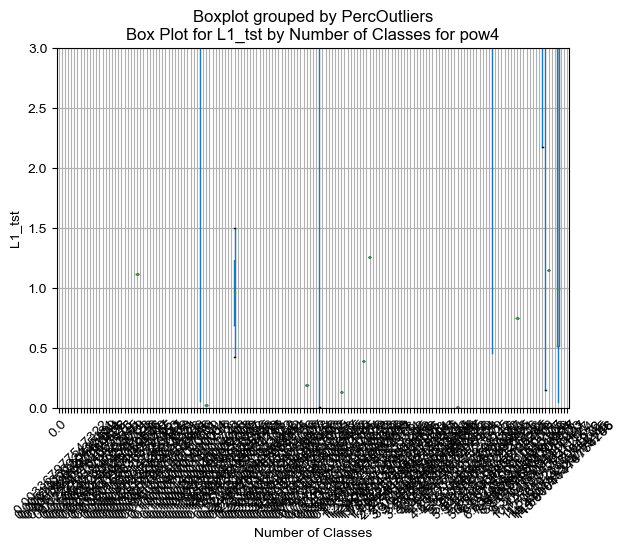

In [90]:

buckets = []

# Create buckets for the first 10 values with a bucket size of 10
buckets = np.arange(0, 1, 0.5).tolist()

# Create buckets for the next 500 values with a bucket size of 100
buckets.extend(np.arange(1, 6, 2.5).tolist())

# Add more buckets
buckets.extend(np.arange(6, 11, 5).tolist())

# Create a bucket for the remaining values with a bucket size of 1000
buckets.append(df_filtered_by_parameter[parameter].max())

df_filtered_by_parameter['Bucket'] = pd.cut(df_filtered_by_parameter[parameter], bins=buckets, right=False)
df_filtered_by_parameter_mmf4['Bucket'] = pd.cut(df_filtered_by_parameter_mmf4[parameter], bins=buckets, right=False)
df_filtered_by_parameter_pow4['Bucket'] = pd.cut(df_filtered_by_parameter_pow4[parameter], bins=buckets, right=False)
df_filtered_by_parameter_exp4['Bucket'] = pd.cut(df_filtered_by_parameter_exp4[parameter], bins=buckets, right=False)
df_combined = pd.concat([df_filtered_by_parameter_mmf4, df_filtered_by_parameter_pow4, df_filtered_by_parameter_exp4])
# Plot box plots for each non-empty bucket
plt.figure(figsize=(10, 6))
df_filtered_by_parameter.boxplot(column=my_error_type, by=parameter)
plt.xlabel('Number of Classes')
plt.ylabel(my_error_type)
plt.ylim(0, 3)
plt.title(f'Box Plot for {my_error_type} by Number of Classes for {my_curve_model}')
plt.xticks(rotation=45)
plt.show()

In [91]:
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
df_combined.dropna()
grouped_df = df_combined.groupby('Bucket')

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=[parameter, 'Friedman Chi-square', 'Friedman p-value'])
grouped_df
# Iterate over each learner grou

# Extract the values for each group
# Iterate over each learner group
for learner, group in grouped_df:
    print(learner)
    # Extract the values for each group
    mmf4_values = group[group['curve_model'] == 'mmf4'][my_error_type].values
    pow4_values = group[group['curve_model'] == 'pow4'][my_error_type].values
    exp4_values = group[group['curve_model'] == 'exp4'][my_error_type].values

    try:
        # Perform Friedman test
        statistic, p_value = friedmanchisquare(mmf4_values, pow4_values, exp4_values)
        # Store the results in the DataFrame
        new_data = pd.DataFrame({'NumberOfClasses': [learner], 'Friedman Chi-square': [statistic], 'Friedman p-value': [p_value]})
        results_df = pd.concat([results_df, new_data], ignore_index=True)        # Perform Wilcoxon signed-rank test for pairwise comparisons
        if p_value < 0.05:  # If the Friedman test is significant
            pairwise_results = []
            # Compare mmf4 vs. pow4
            wilcoxon_stat, wilcoxon_p_value = wilcoxon(mmf4_values, pow4_values)
            pairwise_results.append(('mmf4', 'pow4', wilcoxon_p_value))

            # Compare mmf4 vs. exp4
            wilcoxon_stat, wilcoxon_p_value = wilcoxon(mmf4_values, exp4_values)
            pairwise_results.append(('mmf4', 'exp4', wilcoxon_p_value))

            # Compare pow4 vs. exp4
            wilcoxon_stat, wilcoxon_p_value = wilcoxon(pow4_values, exp4_values)
            pairwise_results.append(('pow4', 'exp4', wilcoxon_p_value))
            
            p_values = [p_value for _, _, p_value in pairwise_results]

            # Apply Holm's correction to the p-values
            rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='holm')

            # Iterate over the pairwise results and corrected p-values
            for (group1, group2, p_value), corrected_p_value, is_rejected in zip(pairwise_results, corrected_p_values, rejected):
                print(corrected_p_value)
                print(f"{group1}: {np.median(eval(group1 + '_values'))}")
                print(f"{group2}: {np.median(eval(group2 + '_values'))}")
                # Check if the corrected p-value is significant
                if corrected_p_value < 0.05:
                    if np.median(eval(group1 + '_values')) < np.median(eval(group2 + '_values')):
                        print(f"Significant difference between {group1} and {group2} for learner {learner}. {group1} is better than {group2}.")
                    else:
                        print(f"Significant difference between {group1} and {group2} for learner {learner}. {group1} is worse than {group2}.")


    except Exception as e:
        print(f"Error in Friedman test for learner {learner}: {str(e)}")


[0.0, 0.5)
2.4447714963547803e-16
mmf4: 0.11406198111722757
pow4: 3.8456648593345463e+21
Significant difference between mmf4 and pow4 for learner [0.0, 0.5). mmf4 is better than pow4.
2.009646618198555e-05
mmf4: 0.11406198111722757
exp4: 0.13427191010428466
Significant difference between mmf4 and exp4 for learner [0.0, 0.5). mmf4 is better than exp4.
5.1064911306729905e-06
pow4: 3.8456648593345463e+21
exp4: 0.13427191010428466
Significant difference between pow4 and exp4 for learner [0.0, 0.5). pow4 is worse than exp4.
[0.5, 1.0)
3.5762786865234375e-07
mmf4: 0.08232838573588253
pow4: 1.619734192023654e+18
Significant difference between mmf4 and pow4 for learner [0.5, 1.0). mmf4 is better than pow4.
0.4389305114746094
mmf4: 0.08232838573588253
exp4: 0.11830698699930248
0.021015644073486328
pow4: 1.619734192023654e+18
exp4: 0.11830698699930248
Significant difference between pow4 and exp4 for learner [0.5, 1.0). pow4 is worse than exp4.
[1.0, 3.5)
7.152557373046875e-07
mmf4: 0.08282648900

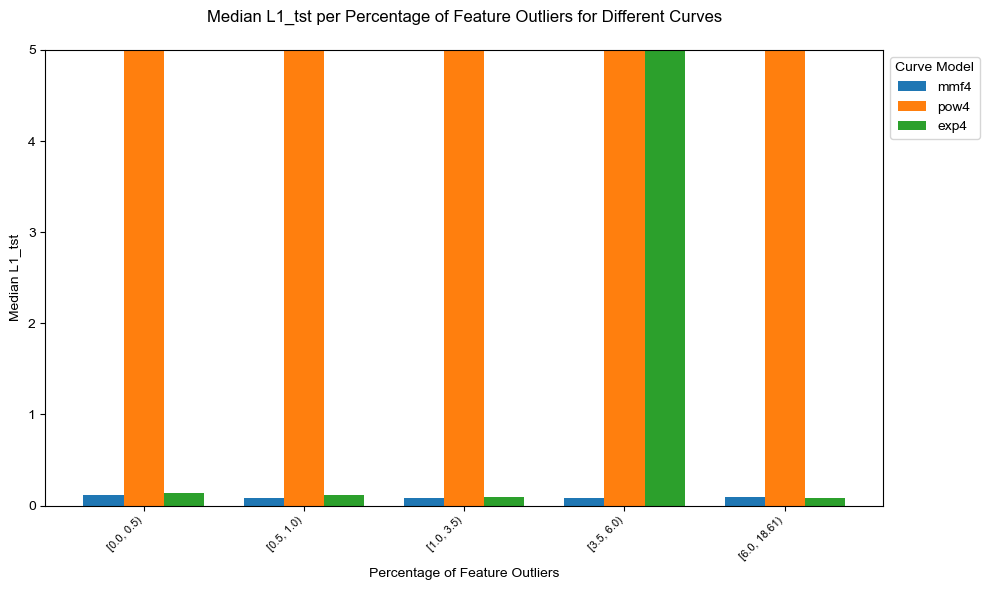

In [92]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size

# Calculate median errors
medians_mmf4 = df_filtered_by_parameter_mmf4.groupby('Bucket')[my_error_type].median()
medians_pow4 = df_filtered_by_parameter_pow4.groupby('Bucket')[my_error_type].median()
medians_exp4 = df_filtered_by_parameter_exp4.groupby('Bucket')[my_error_type].median()
# Generate x-axis positions for the bars
x = np.arange(len(medians_mmf4))

# Width of the bars
bar_width = 0.25

# Plotting bars for mmf4 curve
rects1 = ax.bar(x, medians_mmf4, bar_width, label='mmf4')

# Plotting bars for pow4 curve
rects2 = ax.bar(x + bar_width, medians_pow4, bar_width, label='pow4')

# Plotting bars for exp4 curve
rects3 = ax.bar(x + 2 * bar_width, medians_exp4, bar_width, label='exp4')

# Add labels, title, and legend
ax.set_xlabel('Percentage of Feature Outliers')
ax.set_ylabel(f'Median {my_error_type}')
ax.set_title(f'Median {my_error_type} per Percentage of Feature Outliers for Different Curves', pad=20)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(medians_mmf4.index, rotation=45, fontsize=8, ha='right')
ax.set_ylim(0, 5)
ax.legend(title='Curve Model', bbox_to_anchor=(1, 1), loc='upper left')

error_height = 2
error_height_pow = 1.8
# for rect, height in zip(rects1, medians_mmf4):
#     if height > error_height:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

# for rect, height in zip(rects2, medians_pow4):
#     if height > error_height:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height_pow),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

# for rect, height in zip(rects3, medians_exp4):
#     if height > error_height:
#         ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, error_height),
#                     xytext=(0, 3), textcoords='offset points',
#                     ha='center', va='bottom')

plt.subplots_adjust(bottom=0.5)
# Display the chart
plt.tight_layout()
plt.show()

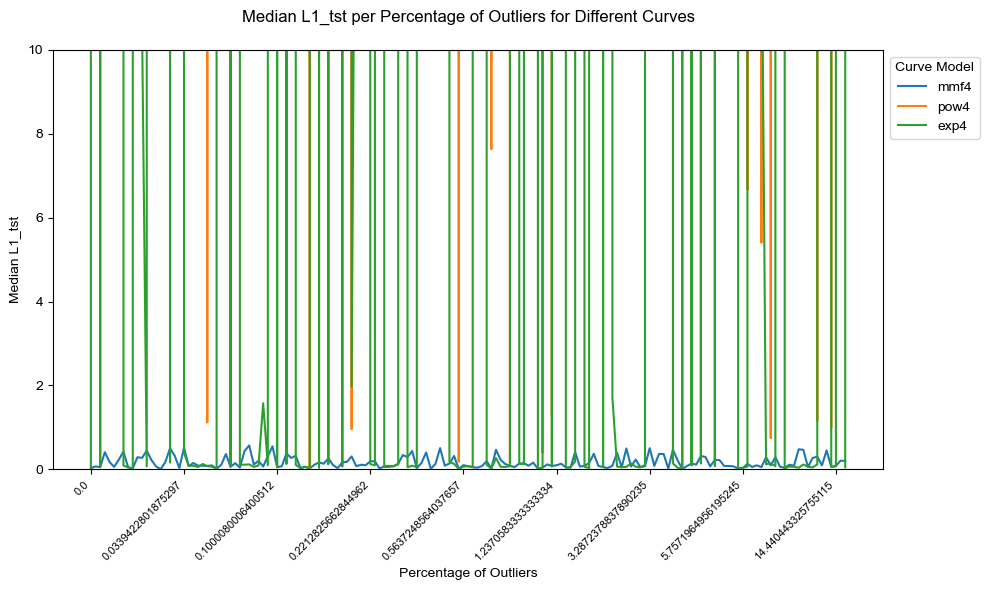

In [93]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size

# Calculate median errors
medians_mmf4 = df_filtered_by_parameter_mmf4.groupby(parameter)[my_error_type].median()
medians_pow4 = df_filtered_by_parameter_pow4.groupby(parameter)[my_error_type].median()
medians_exp4 = df_filtered_by_parameter_exp4.groupby(parameter)[my_error_type].median()

# Generate x-axis positions for the lines
x = np.arange(len(medians_mmf4))

# Plotting lines for mmf4 curve
ax.plot(x, medians_mmf4, label='mmf4')

# Plotting lines for pow4 curve
ax.plot(x, medians_pow4, label='pow4')

# Plotting lines for exp4 curve
ax.plot(x, medians_exp4, label='exp4')

# Add labels, title, and legend
ax.set_xlabel('Percentage of Outliers')
ax.set_ylabel(f'Median {my_error_type}')
ax.set_title(f'Median {my_error_type} per Percentage of Outliers for Different Curves', pad=20)
ax.set_ylim(0, 10)
ax.legend(title='Curve Model', bbox_to_anchor=(1, 1), loc='upper left')
step_size = 20
sampled_indices = np.arange(0, len(medians_mmf4.index), step_size)  # Adjust 'step_size' as needed
sampled_labels = medians_mmf4.index[sampled_indices]
ax.set_xticks(sampled_indices)
ax.set_xticklabels(sampled_labels, rotation=45, fontsize=8, ha='right')

plt.tight_layout()
plt.show()


In [94]:
from scipy.stats import kruskal
grouped_data = df_filtered_by_parameter.groupby('Bucket')[my_error_type].median().dropna()
learner_metrics = []

for group in grouped_data.index:
    # Filter the DataFrame based on the learner
    filtered_data = df_filtered_by_parameter[df_filtered_by_parameter['Bucket'] == group]
    
    # Extract the 'MSE_tst' values from the filtered data
    error_value = filtered_data[my_error_type].values
    
    # Append the error_value array to the learner_metrics list
    learner_metrics.append(error_value)

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*learner_metrics)

p_value

0.0008275178221629489

In [103]:
import scikit_posthocs as sp
# Group the data by 'Bucket' and get the 'my_error_type' values for each bucket
grouped_data = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)
bucket1 = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)[0]
bucket2 = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)[1]
bucket3 = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)[2]
bucket4 = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)[3]
bucket5 = df_filtered_by_parameter.groupby('Bucket')[my_error_type].apply(list)[4]
data = [bucket1, bucket2, bucket3, bucket4, bucket5]

sp.posthoc_conover(data, p_adjust = 'holm')



,1,2,3,4,5
1,1.000000,0.643774,0.643774,0.643774,1.000000
2,0.643774,1.000000,1.000000,1.000000,0.257032
3,0.643774,1.000000,1.000000,1.000000,0.257032
4,0.643774,1.000000,1.000000,1.000000,0.257032
5,1.000000,0.257032,0.257032,0.257032,1.000000


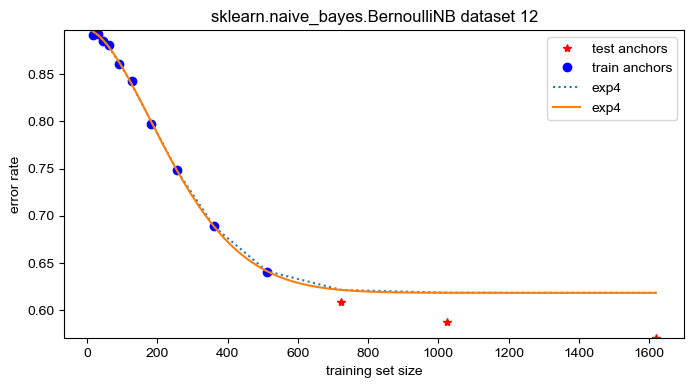

openmlid                                                             12
learner                                 sklearn.naive_bayes.BernoulliNB
max_anchor_seen                                                     512
prediction            [0.104429700480282, 0.10603043500717196, 0.108...
beta                  [5.972394937696008e-05, -1.2766819629830304, 0...
fails_init                                                            0
fails_fit                                                             0
MSE_trn                                                        0.000006
MSE_tst                                                        0.001146
MSE_tst_last                                                   0.002321
L1_trn                                                         0.002142
L1_tst                                                         0.030609
L1_tst_last                                                    0.048178
n                                                               

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,...,percentage,percentage_bucket,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures_x,NumberOfFeatures_y,NumberOfFeatures,NumberOfClasses
0,3,SVC_linear,45,"[0.6871959994766521, 0.7358048075051826, 0.779...","[0.9585686965063442, 65.717112761228, 1.424918...",0,0,5.918595e-07,0.000045,0.000141,...,0.017388,0.05,37.0,37.0,37,37,37,37,37,2
1,3,SVC_linear,64,"[0.6872896626693055, 0.7356441492894228, 0.779...","[1.0179902627671116, 7.256505337543426, 0.8682...",0,0,6.533791e-07,0.000904,0.001647,...,0.024730,0.05,37.0,37.0,37,37,37,37,37,2
2,3,SVC_linear,91,"[0.6873537192715493, 0.7353498699373091, 0.779...","[0.9445764062845252, 1363.9883503403375, 2.047...",0,0,8.374107e-07,0.000273,0.000631,...,0.035162,0.05,37.0,37.0,37,37,37,37,37,2
3,3,SVC_linear,128,"[0.6872911905416228, 0.7354931238245204, 0.779...","[0.9560185696564745, 191.797847699449, 1.64180...",0,0,8.702641e-07,0.000074,0.000196,...,0.049459,0.05,37.0,37.0,37,37,37,37,37,2
4,3,SVC_linear,181,"[0.6870080420321716, 0.7359803560370154, 0.779...","[0.9755968843816757, 22.420258498280724, 1.173...",0,0,1.250014e-06,0.000031,0.000015,...,0.069938,0.10,37.0,37.0,37,37,37,37,37,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723723,42734,sklearn.tree.ExtraTreeClassifier,8192,"[0.6069124382316534, 0.6068719349769798, 0.606...","[1.2272074914077795, -57.17612385505127, 0.000...",0,0,1.241574e-04,0.000265,0.000333,...,0.199130,0.20,20.0,20.0,20,20,20,20,20,3
723724,42734,sklearn.tree.ExtraTreeClassifier,11585,"[0.6057733224352649, 0.6059305920794467, 0.606...","[1.8826720732566837, 709.781423308746, -0.0010...",0,0,1.249676e-04,0.000199,0.000228,...,0.281606,0.40,20.0,20.0,20,20,20,20,20,3
723725,42734,sklearn.tree.ExtraTreeClassifier,16384,"[0.6049948452599763, 0.6052794176922707, 0.605...","[2.60139205065173, 709.782005466877, -0.001688...",0,0,1.223783e-04,0.000182,0.000172,...,0.398260,0.40,20.0,20.0,20,20,20,20,20,3
723726,42734,sklearn.tree.ExtraTreeClassifier,23170,"[0.6040939529608614, 0.6045179965299784, 0.604...","[3.699510568374257, 709.7788620132377, -0.0023...",0,0,1.215016e-04,0.000154,0.000120,...,0.563213,0.80,20.0,20.0,20,20,20,20,20,3


In [163]:
df_curve = df_total[df_total['learner'] == 'sklearn.naive_bayes.BernoulliNB']
row = df_curve[df_curve['curve_model'] == 'exp4'].iloc[35]
# num = np.random.randint(0,len(df_total))
# row = df_total.iloc[num,:]

# print('visualizing the curve fit of row number %d' % row)

plt.figure(figsize=(8,4))

# plots all the points on the curve (red stars)
plot_data2(row)

# plots the points used for training only (blue dots)
plot_trn_data2(row)

# plot the curve fit from the row of the dataframe (dotted)
plot_prediction2(row)

# plot the curve fit using the beta parameters in the dataframe (line)
# this plot is smoother since we can predict any x-value
# this curve should overlap with the curve plotted previously
plot_prediction_smooth2(row)
# show the plot
plt.show()

# show the information of the row
print(row)
df_total

Let us retrieve the fitted curve model and make a new prediction:

In [ ]:
fitted_curve_model = get_fun_model_id(row.beta, row.curve_model)
x_predict = row.anchor_prediction[-1]*2
y_predict = fitted_curve_model(x_predict)
y_predict

# Repeat the fitting procedure
Let us redo a fit to illustrate the fitting procedure.

In [ ]:
# get the X and Y values
# X are training set sizes
# Y are accuracies
[X, Y] = get_XY2(row)

# we need to find the training and test set for the curve data, we do that through the offset
offset = np.argwhere(X == row.max_anchor_seen)[0][0]

# curve training data
X_trn_curve = np.array(X[:offset + 1])
Y_trn_curve = np.array(Y[:offset + 1])

# curve testing data
X_tst_curve = np.array(X[offset + 1:])
Y_tst_curve = np.array(Y[offset + 1:])

experiment_id = '%d-%s-%s-%d' % (row.openmlid,row.learner,row.curve_model,offset)

hash = sha256(experiment_id.encode())
seed = np.frombuffer(hash.digest(), dtype='uint32')
np.random.seed(seed)

# fit the curve model again
[beta_fit_new, fitted_curve_model_new, fails_init, fails_fit] = fit_model(X_trn_curve, Y_trn_curve, X_tst_curve, row.curve_model)

print('best beta found from fitting procedure:')
print(beta_fit_new)
print('the beta provided by the authors:')
print(row.beta)
#assert(beta_fit_new == row.beta)

# Fitting many learning curves
The code in ``fit3_students.py`` takes the file ``lcdb_new.csv`` and fits all learning curve models to all datasets. This procedure takes approximately 20-40 hours to complete. That is why ``fit_students.py`` takes as argument part: part is an integer in [0, 9]. The database is splitted in 10 parts. So if part is 0, the first 10% of the database is processed. This takes about 2-4 hours. I will not do that computation here, because it simply takes extremely long. The results of these computations are stored in ``extrapolations$i.p``, ``anchor_scores$i.p``, ``metrics$i.p``, and these were already loaded above using ``load_from_parts()``. Still, to illustrate how this process went, let us fit all curve models for a single dataset.

Let us first read the learning curve database:

In [ ]:
df_performances = pd.read_csv("database-accuracy.csv")
df_performances

The columns are:
- openmlid: the dataset
- learner: the learner trained
- size_train: the maximum number of training sizes used
- size_test: size of the test set
- outer_seed, inner_seed: the seeds that were used to generate the training, validation and test folds (see ECML paper for details)
- score_train: accuracy on train set
- score_valid: accuracy on validation set
- score_test: accuracy on test set

Note that in my experiments, I computed all the learning curves using the validation set, and never used the test sets.

Let us fit all learning curves for a single dataset that is relatively small, to illustrate the process:

In [ ]:
df_performances_one_dataset = df_performances.query('openmlid == 1468')
df_performances_one_dataset

This code below is taken from ``do_job()`` from ``fit3_students.py``.
Note that some computations result in nans, because some of the fits are so bad, that they cause overflows or divisions by zero.
Fitting the curves, computing the metrics, and computing the X, Y values (anchors and scores mean curve) takes about 2 minutes for this dataset.

In [ ]:
np.seterr(all='print')

print('computing extrapolations...')
# compute the fits
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_performances_one_dataset, 5, True)
df_extrapolations.to_pickle(dir_fitting_results + '/extrapolations_example.gz', protocol=3)

print('computing anchors and scores...')
# compute the X, Y values and store them for later use
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_performances_one_dataset)
df_anchors_and_scores.to_pickle(dir_fitting_results + '/anchors_scores_example.gz', protocol=3)

print('computing metrics....')
# compute the metrics and other information (L2 losses, etc.)
df_metrics = df_compute_metrics_mean_curve(df_extrapolations, df_anchors_and_scores)
df_metrics.to_pickle(dir_fitting_results + '/metrics_example.gz', protocol=3)

Now you have seen how the fitting procedure was done on all the learning curves. Let us now go back to the complete database and do some analysis.

# Cleaning
As you have seen, many of the learning curve fits didn't succeed. That is why we removed some fits that we deemed 'bad'. The criteria for removal are:
- the fitting had to be restarted more than 100 times to get a decent solution (e.g. we gave up trying to perform fitting to avoid infinite loop), we denote this reason as ``fail``.
- we had to try more than 1000 initial points for the fitting to get started at all (also to avoid infinite loops). note that this never happened in any of the experiments. we denote this reason also as ``fail`` if it would ever occur.
- after the fitting has converged, the best solution obtained Nan or Inf values when extrapolating or interpolating the learning curve, we denote this reason as  ``nan_or_inf``
- the MSE on the train, test or test last point was larger than 100 (some performances are so large that they may cause buffer overflows?) we denote this reason as ``too_bad``


In [ ]:
[df_clean, df_removed] = remove_bad_fits(df_total)

Lets have a look what was removed and why:

In [ ]:
df_failed_statistics = failed_fits_statistics(df_removed)
df_failed_statistics

Let us compute the overall percentages of the failed fits compared to all fitting experiments performed:

In [ ]:
df_failed_statistics.iloc[-1,1:5]/len(df_total)

So in total 3.6% of all fitting experiments have been discarded.

# Group results together
For the analysis it is sometimes useful to group all results together, we do that here. Note that this computation takes quite some time: 25 min per performance metric. So I've pickled the results for you.

In [ ]:
fn_MSE_tst_last = dir_fitting_results + '/table_MSE_tst_last.gz'
fn_MSE_tst = dir_fitting_results + '/table_MSE_tst.gz'
fn_MSE_trn = dir_fitting_results + '/table_MSE_trn.gz'

if exists(fn_MSE_tst_last):
    table_MSE_tst_last = pd.read_pickle(fn_MSE_tst_last)
else:
    table_MSE_tst_last = convert_table2(df_clean,'MSE_tst_last')
    table_MSE_tst_last.to_pickle(fn_MSE_tst_last, protocol=3)

if exists(fn_MSE_tst):
    table_MSE_tst = pd.read_pickle(fn_MSE_tst)
else:
    table_MSE_tst = convert_table2(df_clean,'MSE_tst')
    table_MSE_tst.to_pickle(fn_MSE_tst, protocol=3)

if exists(fn_MSE_trn):
    table_MSE_trn = pd.read_pickle(fn_MSE_trn)
else:
    table_MSE_trn = convert_table2(df_clean,'MSE_trn')
    table_MSE_trn.to_pickle(fn_MSE_trn, protocol=3)


Let us look at the resulting tables. For example, let us look at ``table_MSE_tst_last``. This table lists all MSE's for extrapolating to the last point for all experiments (including nans). See below how the new dataframe looks like:

In [ ]:
table_MSE_tst_last

The nans occur because some of the curve models did not find a good fit (and were removed during cleaning), but because of the grouping they popped up again. We can remove rows with any nans as follows.

In [ ]:
table_MSE_tst_last_no_nan_or_inf = remove_rows_with_nan_or_inf(table_MSE_tst_last)
table_MSE_tst_last_no_nan_or_inf

Note that, if we remove a nan row from this dataframe, we can loose quite a lot of information, since only 1 fit has to fail for an entire row to be discarded. So it may not be the best option to remove rows like this... I avoided doing this whenever I could in our paper. For example, for the pairwise comparisons, all rows are used, and only if one of the pairs has a nan, it is removed before the comparison. However, for the Friedman test, any rows containing nans need to be dropped first.

# Preprocessing for ranks and critical diagrams
We have slightly adapted the code of ```https://github.com/hfawaz/cd-diagram``` to compute the ranks and to plot the critical diagrams. This code expects the results in a particular format. Therefore, we first have to do some preprocessing:

In [ ]:
tables_MSE_tst_last, tables_MSE_tst_last_nan = convert_to_cd_tables(filter_table(table_MSE_tst_last))
tables_MSE_tst, tables_MSE_tst_nan = convert_to_cd_tables(filter_table(table_MSE_tst))
tables_MSE_trn, tables_MSE_trn_nan = convert_to_cd_tables(filter_table(table_MSE_trn))

table_MSE_tst_last_all = prepare_data_for_cd(table_MSE_tst_last,drop_nan=True)
table_MSE_tst_last_all_nan = prepare_data_for_cd(table_MSE_tst_last,drop_nan=False)

table_MSE_tst_all = prepare_data_for_cd(table_MSE_tst,drop_nan=True)
table_MSE_tst_all_nan = prepare_data_for_cd(table_MSE_tst,drop_nan=False)

table_MSE_trn_all = prepare_data_for_cd(table_MSE_trn,drop_nan=True)
table_MSE_trn_all_nan = prepare_data_for_cd(table_MSE_trn,drop_nan=False)

tables_MSE_tst_last.insert(0,table_MSE_tst_last_all)
tables_MSE_tst_last_nan.insert(0,table_MSE_tst_last_all_nan)
tables_MSE_tst.insert(0,table_MSE_tst_all)
tables_MSE_tst_nan.insert(0,table_MSE_tst_all_nan)
tables_MSE_trn.insert(0,table_MSE_trn_all)
tables_MSE_trn_nan.insert(0,table_MSE_trn_all_nan)

```filter_table``` filters the experiments so that a list is created with tables, where each table in the resulting list only has the closest anchor to 5%, 10%, 20%, 40% and 80%. ```convert_to_cd_tables``` changes the format of the table to be in the correct format for the critical diagram code for all filtered tables. ```prepare_data_for_cd``` puts the table in the right format for all results. We put all resulting tables in ```tables_MSE_tst_last```, which is a list, where the first item corresponds to all results, and the other list items correspond to 5%, 10%, 20%, 40% and 80%. Let us visualize one of the tables below, this is the data for all experiments (because its the first list item):

In [ ]:
tables_MSE_tst_last[0]

This table does not contain any of the nan rows from before. ```tables_MSE_tst_last_nan``` does contain the data with the nan results included. We keep it around for the pairwise tests.

# Compute the rank tables

We use the Friedman function which computes the ranks for us with the code below. These do not include the nan rows from before. Note that all results are significant according to the Friedman test (otherwise, we wouldn't obtain any results, and the ```wilcoxon_holm``` function would exit prematurely without returning any results).

In [ ]:
rank_list_tst_last = get_ranks_from_tables(tables_MSE_tst_last)
rank_table_tst_last = build_rank_table(rank_list_tst_last)

rank_list_tst = get_ranks_from_tables(tables_MSE_tst)
rank_table_tst = build_rank_table(rank_list_tst)

rank_list_trn = get_ranks_from_tables(tables_MSE_trn)
rank_table_trn = build_rank_table(rank_list_trn)

Let us visualize the rank tables

In [ ]:
rank_table_tst_last

In [ ]:
rank_table_tst

In [ ]:
rank_table_trn

# Critical Diagrams
Now we can visualize the critical diagrams. They are visualized in the Jupyter notebook and saved to EPS files in the current folder. We create all diagrams for extrapolation to the last anchor, to all test anchors, and to the train anchors, for all results and the results filtered by percentage:

In [ ]:
make_all_cd_plots(tables_MSE_tst_last,tables_MSE_tst_last_nan,'MSE last anchors','.eps', dir_plots)
make_all_cd_plots(tables_MSE_tst_last,tables_MSE_tst_last_nan,'MSE last anchors','.png', dir_plots)

In [ ]:
make_all_cd_plots(tables_MSE_tst,tables_MSE_tst_nan,'MSE test anchors','.eps',dir_plots)
make_all_cd_plots(tables_MSE_tst,tables_MSE_tst_nan,'MSE test anchors','.png',dir_plots)

In [ ]:
make_all_cd_plots(tables_MSE_trn,tables_MSE_trn_nan,'MSE train anchors','.eps', dir_plots)
make_all_cd_plots(tables_MSE_trn,tables_MSE_trn_nan,'MSE train anchors','.png', dir_plots)

# Visualize fit performances

In [ ]:

plt.figure(dpi=100,figsize=(10,3))

plot_metric(df_total['MSE_trn'],'MSE train')
plot_metric(df_total['MSE_tst'],'MSE test')
plot_metric(df_total['MSE_tst_last'],'MSE test last')

plt.xlabel('Performance bins (logscale)')
plt.ylabel('Fraction')
plt.legend()
plt.title('Fitting performance')
plt.xlim([1e-7,1e1])

plt.savefig(dir_plots + '/fitting_histogram.eps', bbox_inches='tight')
plt.savefig(dir_plots + '/fitting_histogram.png', bbox_inches='tight')
plt.show()

Preprocess the data for the CDF plot

In [ ]:
max_possible_anchors = {
    d: max(df_total[df_total["openmlid"] == d]["max_anchor_seen"]) for d in pd.unique(df_total["openmlid"])
}

df_for_cdf_plot = df_total.copy()
df_for_cdf_plot["relevant_max_anchor"] = [get_relevant_max_anchor(max_possible_anchors[openmlid]) for openmlid in df_total["openmlid"]]

df_for_cdf_plot_filtered = df_for_cdf_plot[df_for_cdf_plot["max_anchor_seen"] == df_for_cdf_plot["relevant_max_anchor"]]


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(14,3))

lw_default = 0.8
ls_default = ":"

i = 0

winners_fit = ["pow4", "mmf4", "exp4", "wbl4"]
winners_extrapolate = ["mmf4", "exp4", "wbl4", "last1"]

for [curve_model, df_curve_model] in df_for_cdf_plot_filtered.groupby('curve_model'):

    #plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)

    lw = 1 if curve_model in winners_fit else lw_default
    ls = "-" if curve_model in winners_fit else ls_default

    empirical_cdf(ax1,df_curve_model['MSE_trn'],curve_model,ls=ls,label=curve_model, linewidth=lw)
    i += 1
    ax1.set_xlabel('x (logscale)')
    ax1.set_xscale('log')
    ax1.set_xlim([1e-7,1])
    ax1.set_ylabel('F(x)')
    ax1.set_title('MSE train anchors')


i = 0
for [curve_model, df_curve_model] in df_total.groupby('curve_model'):

    #if i > 5:
    #   break
    lw = 1 if curve_model in winners_extrapolate else lw_default
    ls = "-" if curve_model in winners_extrapolate else ls_default

    #plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)
    empirical_cdf(ax2,df_curve_model['MSE_tst_last'],curve_model,ls=ls,label=curve_model, linewidth=lw)
    i += 1

    ax2.set_xlabel('x (logscale)')
    ax2.set_title('MSE test anchors')
    ax2.set_xscale('log')
    ax2.set_xlim([1e-7,1e3])


handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=8)

plt.subplots_adjust(wspace=0.05)

plt.savefig(dir_plots + '/fitting_cdf.eps', bbox_inches='tight')
plt.savefig(dir_plots + '/fitting_cdf.png', bbox_inches='tight')
plt.show()

# Generate Latex
Generates a nice report on all fitting results in latex and compiles it with pdflatex.

In [ ]:
with open("fit_report_start.tex") as f_start:
    with open("fit_report.tex", "w") as f_new:
        for line in f_start:
            f_new.write(line)

tables = [rank_table_tst_last,rank_table_tst,rank_table_trn]
captions = ['Ranks for extrapolating to the last test anchor.','Ranks for extrapolating to all test anchors.','Ranks for the training MSE.']
for i, table in enumerate(tables):
    print_pretty_rank_table_transpose(table, toFile='fit_report.tex', caption=captions[i])

with open('fit_report.tex',"a") as f:
    f.write('\\end{document}')

In [ ]:
import subprocess

batcmd="pdflatex fit_report.tex"
result = subprocess.check_output(batcmd, shell=True, stderr=subprocess.STDOUT)
result